In [1]:
import pyro
import torch
import wandb
import os

from inference.bayesian.models import TorchModel
from inference.frequentist.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

In [2]:
config = {
            "dataset": "spain",
            "model_widths": [512, 256, 128, 1],
            "activation": "tanh",
            "dim_reduction": False,
            "inference": "q_regr",
            "lr": 0.0006,
            "num_iterations": 1000,
            "plot": True,
            "sweep": False
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
Ytr, train_embedding, Yval, val_embedding, Yte, test_embedding, diffXte, diffYte = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 907, Val: 455, Te: 455


# Quantile Regression

In [5]:
quantiles = [0, 0.005]
for n in range(39):
    quantiles.append(0.025*(n+1))
quantiles.append(0.995)

QR_torch_model = TorchModel(config.model_widths, config.activation, quantiles=quantiles).to(device)

In [6]:
predictive, diagnostics = inference(config, QR_torch_model, None,
                                    X_train=train_embedding, Y_train=Ytr, 
                                    X_val=val_embedding, Y_val=Yval,
                                    X_test=test_embedding, Y_test=Yte,
                                    quantiles=quantiles)

Epoch 370:  37%|███▋      | 369/1000 [00:10<00:18, 33.89it/s, loss=0.102]


Early stopping


<Figure size 600x600 with 0 Axes>

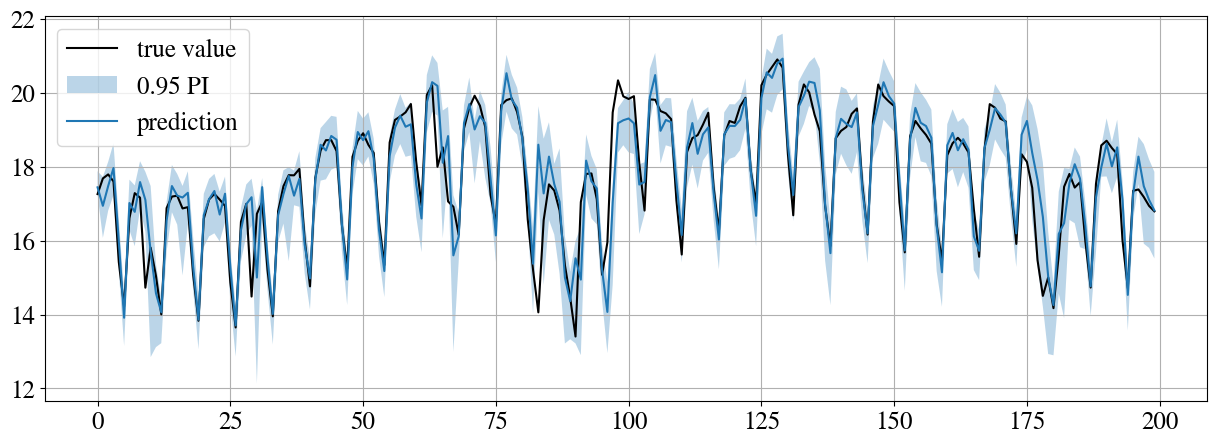

In [7]:
plot_forecast(predictive, Yte, diffXte.squeeze(), diffYte.squeeze())

In [8]:
for k, v in diagnostics.items():
    print(k, "\t", v)

train_time 	 1.46875
final_loss 	 0.15529797971248627
inference_time 	 0.0
cal_error 	 0.005190257434433793
new_cal_error 	 0.009553224043908813
width 	 2.5845098
new_width 	 0.8905445282710106
coverage 	 0.9487917146144994
avg_length 	 0.2709965
new_coverage 	 0.4299961641733794
new_avg_length 	 0.09337726180253848
mse 	 0.541305
new_mse 	 1.0908551
crps 	 0.3454167902241179
new_crps 	 0.34659524323740787


In [11]:
print("training time: ", diagnostics['train_time'])
print("calibration error: ", diagnostics['cal_error'])

training time:  0.09375
calibration error:  0.00456548852937765
